<a href="https://colab.research.google.com/github/ssnirgudkar/Datasetpaper-final/blob/main/deeplab2_Finalpaper_submission.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Use this version as the most final

creates model folder automatically

to do - 
1. Batch size should be 10 (identical with UNet, PSPNet) - This batch size gives OOM. 7 is the max we can go with regular RAM
2. Image size 512*512 : Is this really needed? We are not using imagenet weights anyway. - Updted to use the actual 
3. Shuffle the training and validation images. Use the code which was shared earlier. I think this will be beneficial.

## we have to keep batchsize = 2 or more. It does not run with batch size 1. Image will be resized to 512*512
## mask datatype is uint8. segments.ai semantic masks are uint8 and instance masks are uint16. We need to be careful about which type of masks are getting processed else it reads masks as 0. 
##the resize was changed to nearest. but we can check if thats needed. bilinear is default. So we can try to keep it as bilinera and that shld also work. With this run, objects were not coming up well. objects and background was getting mixed

Run2 11/11 - Uncommented the 127.5-1 code. so now both image and masks are float 32. also changed the nearest back to bilnear. changed the batch size from 10 to 4. running with 50 epochs to see how it works.

Train images - 
Val images - 
Test images 
Epochs - 500 
Train time -

##Run3 - 
Train images - 3438
Val images - 982
Test images - 492
Epochs - 50 
Train time - 3 hrs 49 min
Test time - 
Any preloaded weights - NO. Imagenet weights are not used
The masks are uint8. the code had it as uint16. Hence we were getting pixel values of 257. fixed that
Model - deeplab-finalpapersubmission_V1

##Run4 - 
Train images - 26081
Val images - 7452
Test images - 3726
Epochs - 25(will break into 4 parts as this is a big dataset.  
Train time - 10 hrs 40 min
Test time - 
Any preloaded weights - NO. Imagenet weights are not used
Model - deeplab-finalpapersubmission (the next ones will be submission2,3 and 4)
infernce folder - IRDatasetFinal-Inferences
loss: 0.0623 - accuracy: 0.9790 

##Run5 - 2020 & 2021
loss: 0.0361 - accuracy: 0.9873 - val_loss: 3.3841 - val_accuracy: 0.7209
epochs - 50 
ran with 2020 and 2021 dataset only 
Model - deeplab folder - deeplab-finalpapersubmission-2020only (there's another with 2020-only. need to check)
training time - 9 hrs, 27 min

# https://keras.io/examples/vision/deeplabv3_plus/

In [2]:
import zipfile
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetConsolidated/train.zip", "r")
#zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/train.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetConsolidated/trainannot.zip", "r")
#zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/trainannot.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetConsolidated/val.zip", "r")
#zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/val.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetConsolidated/valannot.zip", "r")
#zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/valannot.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()
'''
zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/test.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()

zip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/testannot.zip", "r")
zip_ref.extractall("/content/IRDatasetFinal")
zip_ref.close()
'''

'\nzip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/test.zip", "r")\nzip_ref.extractall("/content/IRDatasetFinal")\nzip_ref.close()\n\nzip_ref = zipfile.ZipFile("/content/drive/MyDrive/IRDatasetAfter2019/testannot.zip", "r")\nzip_ref.extractall("/content/IRDatasetFinal")\nzip_ref.close()\n'

In [4]:
import os 
APP_FOLDER = '/content/IRDatasetFinal/train'
totalFiles = 0
totalDir = 0

for base, dirs, files in os.walk(APP_FOLDER):
    print('Searching in : ',base)
    for directories in dirs:
        totalDir += 1
    for Files in files:
        totalFiles += 1
   

print('Total number of files',totalFiles)
print('Total Number of directories',totalDir)
print('Total:',(totalDir + totalFiles))

Searching in :  /content/IRDatasetFinal/train
Total number of files 26081
Total Number of directories 0
Total: 26081


In [5]:
import os
import cv2
import numpy as np
from glob import glob
from scipy.io import loadmat
import matplotlib.pyplot as plt
import random

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Downloading the data We will use the Crowd Instance-level Human Parsing Dataset for training our model. The Crowd Instance-level Human Parsing (CIHP) dataset has 38,280 diverse human images. Each image in CIHP is labeled with pixel-wise annotations for 20 categories, as well as instance-level identification. This dataset can be used for the "human part segmentation" task.

In [6]:
#!gdown https://drive.google.com/uc?id=1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz
#!unzip -q instance-level-human-parsing.zip

In [ ]:
'''
from google.colab import drive
drive.mount('/content/drive', force_remount = True)
# to copy files from google drive to colab memory
#%cp -av /content/drive/MyDrive/TheIRDatasetMini/ TheIRDatasetMini
'''

Mounted at /content/drive


In [7]:
IMAGE_SIZE_WIDTH = 640
IMAGE_SIZE_HEIGHT = 512
BATCH_SIZE = 7
NUM_CLASSES = 7
#DATA_DIR = '/content/drive/MyDrive/TheIRDatasetMini_backup'
DATA_DIR = '/content/IRDatasetFinal'
#DATA_DIR = '/content/drive/MyDrive/TheIRDataset'
#DATA_DIR = '/content/drive/MyDrive/IR -test'

#VAL_DATA_DIR = "./instance-level_human_parsing/instance-level_human_parsing/Training"
#NUM_TRAIN_IMAGES = 80
#NUM_VAL_IMAGES = 10

'''
train_images = sorted(glob(os.path.join(DATA_DIR, "train/*")))[:NUM_TRAIN_IMAGES]
train_masks = sorted(glob(os.path.join(DATA_DIR, "trainannot/*")))[:NUM_TRAIN_IMAGES]
val_images = sorted(glob(os.path.join(DATA_DIR, "train/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
val_masks = sorted(glob(os.path.join(DATA_DIR, "trainannot/*")))[
    NUM_TRAIN_IMAGES : NUM_VAL_IMAGES + NUM_TRAIN_IMAGES
]
'''
train_images = sorted(glob(os.path.join(DATA_DIR, "train/*"))) 
train_masks = sorted(glob(os.path.join(DATA_DIR, "trainannot/*"))) 
indices_train = random.sample(range(len(train_images)), len(train_images))
train_images = list(map(train_images.__getitem__, indices_train))
train_masks = list(map(train_masks.__getitem__, indices_train))
print("type of train_images = ", type(train_images))

val_images = sorted(glob(os.path.join(DATA_DIR, "val/*")))
val_masks = sorted(glob(os.path.join(DATA_DIR, "valannot/*")))
indices_val = random.sample(range(len(val_images)), len(val_images))
val_images = list(map(val_images.__getitem__, indices_val))
val_masks = list(map(val_masks.__getitem__, indices_val))

#test_images = sorted(glob(os.path.join(DATA_DIR, "test/*")))
#test_masks = sorted(glob(os.path.join(DATA_DIR, "testannot/*")))


def read_image(image_path, mask=False):
    image = tf.io.read_file(image_path)
    print("image=", image)
    if mask:
        image = tf.image.decode_png(image, channels=0, dtype=tf.uint8)
        #print("mask 1st read", image)
        #print("Max value of mask as per tef.reduce are", tf.reduce_max(image))
        image.set_shape([None, None, 1])
        #image = tf.cast(image, dtype=tf.float32)
        #print("mask 2nd read", image)
        image = tf.image.resize(images=image, method= 'nearest', size=[IMAGE_SIZE_WIDTH, IMAGE_SIZE_HEIGHT])
        #print("mask 3rd read after resize", image)
        #print('final image' ,image)
        #print('unique values of tensor' , tf.unique(image))
    else:
        image = tf.image.decode_png(image, channels=3, dtype=tf.uint8)
        #print("1st step in read image", image)
        image.set_shape([None, None, 3])
        image = tf.cast(image, dtype=tf.float32)
        #print("2nd step in read image", image)
        image = tf.image.resize(images=image, method= 'bilinear', size=[IMAGE_SIZE_WIDTH, IMAGE_SIZE_HEIGHT])
        image = image / 127.5 - 1
        #print("image looks like", image)
    return image


def load_data(image_list, mask_list):
    image = read_image(image_list)
    mask = read_image(mask_list, mask=True)
    return image, mask


def data_generator(image_list, mask_list):
    dataset = tf.data.Dataset.from_tensor_slices((image_list, mask_list))
    dataset = dataset.map(load_data, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
    return dataset


train_dataset = data_generator(train_images, train_masks)
val_dataset = data_generator(val_images, val_masks)

read_image(train_masks[20], mask=True)

#print ((np.unique(cv2.imread(train_masks[1],cv2.IMREAD_UNCHANGED))))


#print("Train Dataset:", train_dataset)
#print("Val Dataset:", val_dataset)

type of train_images =  <class 'list'>
image= Tensor("ReadFile:0", shape=(), dtype=string)
image= Tensor("ReadFile_1:0", shape=(), dtype=string)
image= Tensor("ReadFile:0", shape=(), dtype=string)
image= Tensor("ReadFile_1:0", shape=(), dtype=string)
image= tf.Tensor(b"\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x02\x80\x00\x00\x02\x00\x08\x00\x00\x00\x007\x16\x82'\x00\x00\x07\xeeIDATx\x9c\xed\xdc\xdbV\xe2H\x00@\xd1\xd06\xff\xff\xc1\xae^\xce\xc3h7B\x12\x02\x02\xa7\xc4\xbd_T\xc2\xa5H\x0eE\xc2\xc5i\x02\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\xf8Q\xf6\xf5\x00\x18\xda\xee\xbeW\xff\x9e\xdf\xeb}o\x85\xef\xeb\xba\x00\xf7\xd3\xb4\xa1\xaa\xc3\xc9O\x82\x

<tf.Tensor: shape=(640, 512, 1), dtype=uint8, numpy=
array([[[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       [[0],
        [0],
        [0],
        ...,
        [0],
        [0],
        [0]],

       ...,

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]],

       [[1],
        [1],
        [1],
        ...,
        [1],
        [1],
        [1]]], dtype=uint8)>

In [ ]:
#print(train_masks)
print(train_images)
print(train_masks)

In [8]:
def convolution_block(
    block_input,
    num_filters=256,
    kernel_size=3,
    dilation_rate=1,
    padding="same",
    use_bias=False,
):
    x = layers.Conv2D(
        num_filters,
        kernel_size=kernel_size,
        dilation_rate=dilation_rate,
        padding="same",
        use_bias=use_bias,
        kernel_initializer=keras.initializers.HeNormal(),
    )(block_input)
    x = layers.BatchNormalization()(x)
    return tf.nn.relu(x)


def DilatedSpatialPyramidPooling(dspp_input):
    dims = dspp_input.shape
    x = layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
    x = convolution_block(x, kernel_size=1, use_bias=True)
    out_pool = layers.UpSampling2D(
        size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",
    )(x)

    out_1 = convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
    out_6 = convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
    out_12 = convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
    out_18 = convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

    x = layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
    output = convolution_block(x, kernel_size=1)
    return output


In [9]:
def DeeplabV3Plus(image_size_width, image_size_height, num_classes):
    model_input = keras.Input(shape=(image_size_width, image_size_height, 3))
    resnet50 = keras.applications.ResNet50(
        #weights="imagenet", include_top=False, input_tensor=model_input - removed imagenet weights
        weights=None, include_top=False, input_tensor=model_input
    )
    x = resnet50.get_layer("conv4_block6_2_relu").output
    x = DilatedSpatialPyramidPooling(x)

    print("x shape 1 value", x.shape[1] )
    print("x shape 2 value", x.shape[2] )

    print("size is", image_size_width // 4 // x.shape[1], image_size_height // 4 // x.shape[2])

    input_a = layers.UpSampling2D(
        size=(image_size_width // 4 // x.shape[1], image_size_height // 4 // x.shape[2]),
        interpolation="bilinear",
    )(x)
    
    input_b = resnet50.get_layer("conv2_block3_2_relu").output
    input_b = convolution_block(input_b, num_filters=48, kernel_size=1)

    x = layers.Concatenate(axis=-1)([input_a, input_b])
    x = convolution_block(x)
    x = convolution_block(x)
    x = layers.UpSampling2D(
        size=(image_size_width // x.shape[1], image_size_height // x.shape[2]),
        interpolation="bilinear",
    )(x)
    model_output = layers.Conv2D(num_classes, kernel_size=(1, 1), padding="same")(x)
    return keras.Model(inputs=model_input, outputs=model_output)


model = DeeplabV3Plus(image_size_width=IMAGE_SIZE_WIDTH, 
                      image_size_height=IMAGE_SIZE_HEIGHT,
                      num_classes=NUM_CLASSES)
model.summary()

x shape 1 value 40
x shape 2 value 32
size is 4 4
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 640, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 646, 518, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 320, 256, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                            

Epoch 1/25
3725/3725 [==============================] - ETA: 0s - loss: 0.1674 - accuracy: 0.9444INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3725/3725 [==============================] - 2034s 541ms/step - loss: 0.1674 - accuracy: 0.9444 - val_loss: 0.1056 - val_accuracy: 0.9629
Epoch 2/25
3725/3725 [==============================] - ETA: 0s - loss: 0.0949 - accuracy: 0.9666INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3725/3725 [==============================] - 2017s 541ms/step - loss: 0.0949 - accuracy: 0.9666 - val_loss: 0.0795 - val_accuracy: 0.9713
Epoch 3/25
3725/3725 [==============================] - ETA: 0s - loss: 0.0720 - accuracy: 0.9742INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3725/3725 [==============================] - 1958s 526ms/step - loss: 0.0720 - accuracy: 0.9742 - val_loss: 0.0605 - val_accuracy: 0.9780
Epoch 4/25
3725/3725 [==============================] - 1987s 534ms/step - loss: 0.0584 - accuracy: 0.9787 - val_loss: 0.0633 - val_accuracy: 0.9775
Epoch 5/25
3725/3725 [==============================] - ETA: 0s - loss: 0.0499 - accuracy: 0.9815INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3725/3725 [==============================] - 2019s 542ms/step - loss: 0.0499 - accuracy: 0.9815 - val_loss: 0.0486 - val_accuracy: 0.9820
Epoch 6/25
3725/3725 [==============================] - ETA: 0s - loss: 0.0437 - accuracy: 0.9835INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3725/3725 [==============================] - 2019s 542ms/step - loss: 0.0437 - accuracy: 0.9835 - val_loss: 0.0447 - val_accuracy: 0.9832
Epoch 7/25
3725/3725 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9850INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3725/3725 [==============================] - 2017s 541ms/step - loss: 0.0389 - accuracy: 0.9850 - val_loss: 0.0412 - val_accuracy: 0.9845
Epoch 8/25
3725/3725 [==============================] - ETA: 0s - loss: 0.0371 - accuracy: 0.9857INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3725/3725 [==============================] - 1963s 527ms/step - loss: 0.0371 - accuracy: 0.9857 - val_loss: 0.0379 - val_accuracy: 0.9856
Epoch 9/25
3725/3725 [==============================] - 1988s 534ms/step - loss: 0.0335 - accuracy: 0.9868 - val_loss: 0.0400 - val_accuracy: 0.9851
Epoch 10/25
3725/3725 [==============================] - ETA: 0s - loss: 0.0316 - accuracy: 0.9875INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3725/3725 [==============================] - 2019s 542ms/step - loss: 0.0316 - accuracy: 0.9875 - val_loss: 0.0333 - val_accuracy: 0.9870
Epoch 11/25
3725/3725 [==============================] - 1930s 518ms/step - loss: 0.0299 - accuracy: 0.9880 - val_loss: 0.0350 - val_accuracy: 0.9866
Epoch 12/25
3725/3725 [==============================] - ETA: 0s - loss: 0.0285 - accuracy: 0.9887INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3725/3725 [==============================] - 2019s 542ms/step - loss: 0.0285 - accuracy: 0.9887 - val_loss: 0.0303 - val_accuracy: 0.9880
Epoch 13/25
3725/3725 [==============================] - 1986s 533ms/step - loss: 0.0275 - accuracy: 0.9890 - val_loss: 0.0312 - val_accuracy: 0.9878
Epoch 14/25
3725/3725 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9896INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3725/3725 [==============================] - 2019s 542ms/step - loss: 0.0256 - accuracy: 0.9896 - val_loss: 0.0286 - val_accuracy: 0.9886
Epoch 15/25
3725/3725 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9899INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3725/3725 [==============================] - 2017s 541ms/step - loss: 0.0249 - accuracy: 0.9899 - val_loss: 0.0285 - val_accuracy: 0.9888
Epoch 16/25
3725/3725 [==============================] - ETA: 0s - loss: 0.0249 - accuracy: 0.9899INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3725/3725 [==============================] - 2020s 542ms/step - loss: 0.0249 - accuracy: 0.9899 - val_loss: 0.0273 - val_accuracy: 0.9891
Epoch 17/25
3725/3725 [==============================] - 1990s 534ms/step - loss: 0.0233 - accuracy: 0.9905 - val_loss: 0.0295 - val_accuracy: 0.9884
Epoch 18/25
3725/3725 [==============================] - 1990s 534ms/step - loss: 0.0224 - accuracy: 0.9908 - val_loss: 0.0280 - val_accuracy: 0.9891
Epoch 19/25
3725/3725 [==============================] - 1990s 534ms/step - loss: 0.0209 - accuracy: 0.9913 - val_loss: 0.0282 - val_accuracy: 0.9890
Epoch 20/25
3725/3725 [==============================] - ETA: 0s - loss: 0.0211 - accuracy: 0.9913INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3725/3725 [==============================] - 2021s 543ms/step - loss: 0.0211 - accuracy: 0.9913 - val_loss: 0.0260 - val_accuracy: 0.9897
Epoch 21/25
3725/3725 [==============================] - 1931s 518ms/step - loss: 0.0199 - accuracy: 0.9917 - val_loss: 0.0266 - val_accuracy: 0.9896
Epoch 22/25
3725/3725 [==============================] - ETA: 0s - loss: 0.0207 - accuracy: 0.9915INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3725/3725 [==============================] - 2021s 542ms/step - loss: 0.0207 - accuracy: 0.9915 - val_loss: 0.0254 - val_accuracy: 0.9900
Epoch 23/25
3725/3725 [==============================] - 1989s 534ms/step - loss: 0.0186 - accuracy: 0.9922 - val_loss: 0.0259 - val_accuracy: 0.9899
Epoch 24/25
3725/3725 [==============================] - ETA: 0s - loss: 0.0188 - accuracy: 0.9921INFO:tensorflow:Assets written to: /content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


3725/3725 [==============================] - 2021s 542ms/step - loss: 0.0188 - accuracy: 0.9921 - val_loss: 0.0251 - val_accuracy: 0.9900
Epoch 25/25
3725/3725 [==============================] - 1989s 534ms/step - loss: 0.0183 - accuracy: 0.9924 - val_loss: 0.0261 - val_accuracy: 0.9897


Text(0.5, 0, 'epoch')

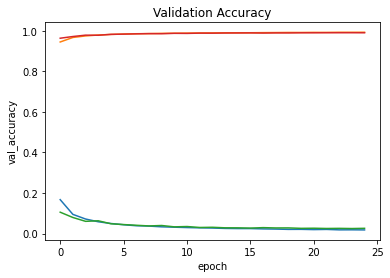

In [10]:
#### This is the training cell
loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss=loss,
    metrics=["accuracy"],
)

my_callbacks = [
    #tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/Logs/Unet-7classes-finalpapersubmission'),
    #keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Models/deeplab/deeplab-finalpapersubmission-20201only", save_freq = 'epoch', save_best_only=True)
    #keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Models/deeplab/deeplab-revisedcode-2020only", save_freq = 'epoch', save_best_only=True)
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled", save_freq = 'epoch', save_best_only=True)
]
history = model.fit(train_dataset, validation_data=val_dataset, callbacks = my_callbacks, epochs=25)
plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
#plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
#plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
#plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
#plt.show()

#model.save("/content/drive/MyDrive/Models/deeplab/deeplab-finalpapersubmission-2020only")

In [ ]:
## this is to retrain the saved model - RUN#2
reconstructed_model = keras.models.load_model("/content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled")
print("model loaded")

my_callbacks = [
    #tf.keras.callbacks.TensorBoard(log_dir='/content/drive/MyDrive/Logs/Unet-7classes-finalpapersubmission'),
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Models/deeplab/deeplab-7classes-finalpapersubmission_2019&2020_shuffled", save_freq = 'epoch', save_best_only=True)

               ]

history = reconstructed_model.fit(train_dataset, validation_data=val_dataset, callbacks = my_callbacks, epochs=50)

plt.plot(history.history["loss"])
plt.title("Training Loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["accuracy"])
plt.title("Training Accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_loss"])
plt.title("Validation Loss")
plt.ylabel("val_loss")
plt.xlabel("epoch")
plt.show()

plt.plot(history.history["val_accuracy"])
plt.title("Validation Accuracy")
plt.ylabel("val_accuracy")
plt.xlabel("epoch")
plt.show()

#commented below as checkpoint already has save best. else it will create a duplicate
#print("model to be saved")
#reconstructed_model.save("/content/drive/MyDrive/Models/deeplab/deeplab-finalpapersubmission-2020only")
#print("model saved")